In [20]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [21]:
import os, getpass
import math

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Here, we'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [22]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## I added my extra tools like subtract and factorial

In [23]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b
def subtract(a: int, b: int) -> int:
    """Subtracts the second number from the first.
    Args:
          a: first int
          b: second int
    
    """
    return a - b
def factorial(n: int) -> int:
    """Calculates the factorial of a non-negative integer.
    Args:
          a: first int
    """
    if n < 0:
        return "Error: Factorial is not defined for negative numbers."
    return math.factorial(n)


tools = [add, multiply, divide,subtract, factorial]
llm = ChatOpenAI(model="gpt-4o")

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

## made a prompt for llm to act on

In [24]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a powerful helper whose task is to perform arithmetic operations on a set of inputs given to you.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## I created a graph and this time I added a loop bw the tools and the assisstant which forms a simple ReAct architechture, and also added all my tools including the factorial and subtract tools

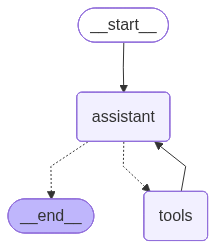

In [25]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## I tested it out by giving it multiple tool calls simultneously 

In [26]:
messages = [HumanMessage(content="Subtract 77 and 59. divide the output by 3. multiply the output by 2")]
messages = react_graph.invoke({"messages": messages})

## we can see it calls multiple tools in a loop

In [27]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Subtract 77 and 59. divide the output by 3. multiply the output by 2
================================== Ai Message ==================================
Tool Calls:
  subtract (call_J6jnOXhRObeIJkyMrC87dZYF)
 Call ID: call_J6jnOXhRObeIJkyMrC87dZYF
  Args:
    a: 77
    b: 59
================================= Tool Message =================================
Name: subtract

18
================================== Ai Message ==================================
Tool Calls:
  divide (call_Qw3sQtT4CJYaIUHQt2y4VmO7)
 Call ID: call_Qw3sQtT4CJYaIUHQt2y4VmO7
  Args:
    a: 18
    b: 3
================================= Tool Message =================================
Name: divide

6.0
================================== Ai Message ==================================
Tool Calls:
  multiply (call_jjxFOGuIt0sW9YlDFCf3yQB6)
 Call ID: call_jjxFOGuIt0sW9YlDFCf3yQB6
  Args:
    a: 6
    b: 2
================================= Tool Mess

## Another example using my tools

In [28]:
messages = [HumanMessage(content="Add 2 and 3. Take the factorial of that number. Divide it by 10. add 4 to the output. finally subtract 300 from the output")]
messages = react_graph.invoke({"messages": messages})

In [29]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 2 and 3. Take the factorial of that number. Divide it by 10. add 4 to the output. finally subtract 300 from the output
================================== Ai Message ==================================
Tool Calls:
  add (call_1eRhuO55WuAwiEHZCQQezCu2)
 Call ID: call_1eRhuO55WuAwiEHZCQQezCu2
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================
Tool Calls:
  factorial (call_yx2RyZafGcgteIehFzZb6m3x)
 Call ID: call_yx2RyZafGcgteIehFzZb6m3x
  Args:
    n: 5
================================= Tool Message =================================
Name: factorial

120
================================== Ai Message ==================================
Tool Calls:
  divide (call_q4ZjAYuvLxE6KWqaaR6QvP9q)
 Call ID: call_q4ZjAYuvLxE6KWqaaR6QvP9q
  Args:
    a: 120
    b: 10
=====

In [30]:
messages = [HumanMessage(content="Add 4 and 1, factorial the output, divide the output by 10, add 4, multiply it by 5, subtract 30 from the output and then subtract 43 from the output and finally take the factorial")]
messages = react_graph.invoke({"messages": messages})

## another example which uses all the tools which I have defined 

In [31]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 4 and 1, factorial the output, divide the output by 10, add 4, multiply it by 5, subtract 30 from the output and then subtract 43 from the output and finally take the factorial
================================== Ai Message ==================================
Tool Calls:
  add (call_PS468gJ7Y7wrOznviBvTcNlh)
 Call ID: call_PS468gJ7Y7wrOznviBvTcNlh
  Args:
    a: 4
    b: 1
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================
Tool Calls:
  factorial (call_v2f5kV93CebXjxhecPFhKoe4)
 Call ID: call_v2f5kV93CebXjxhecPFhKoe4
  Args:
    n: 5
================================= Tool Message =================================
Name: factorial

120
================================== Ai Message ==================================
Tool Calls:
  divide (call_Acr233nrH32YauNFxB919Cfq)
 Call ID: call_A

## We can see our agent in LangSmith stduio

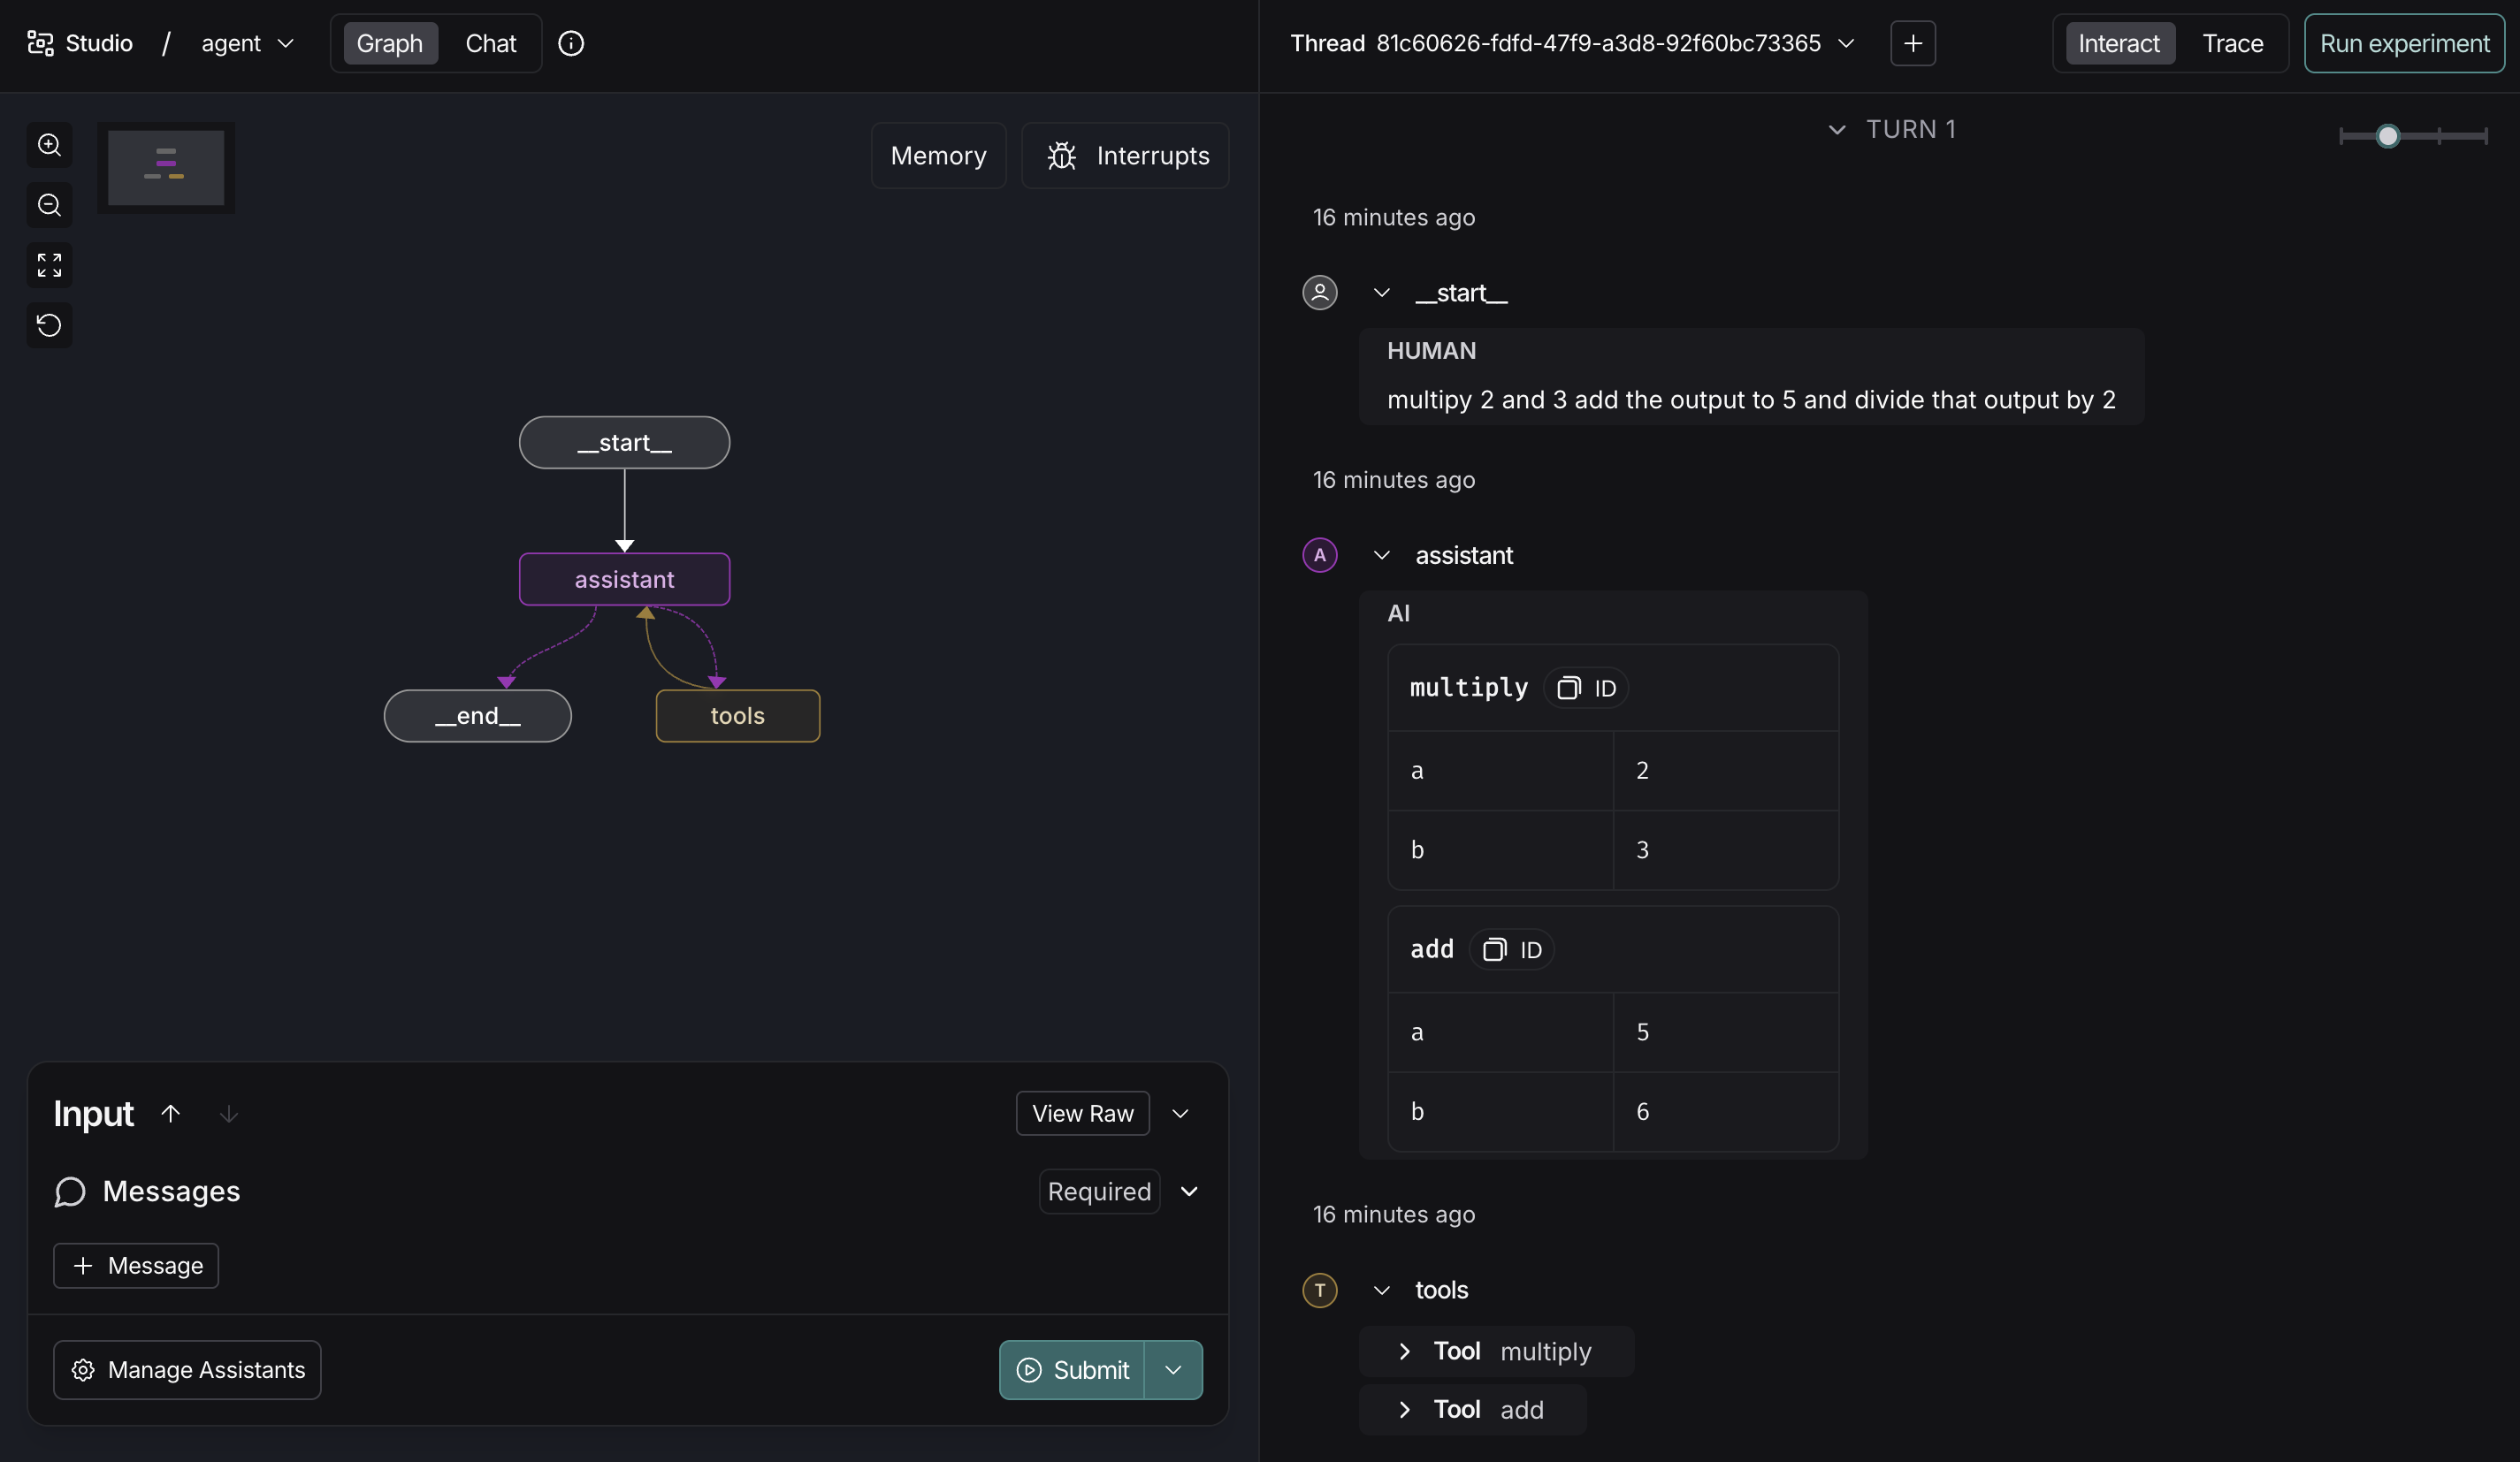

## We can see here it is calling multiple functions in a loop :

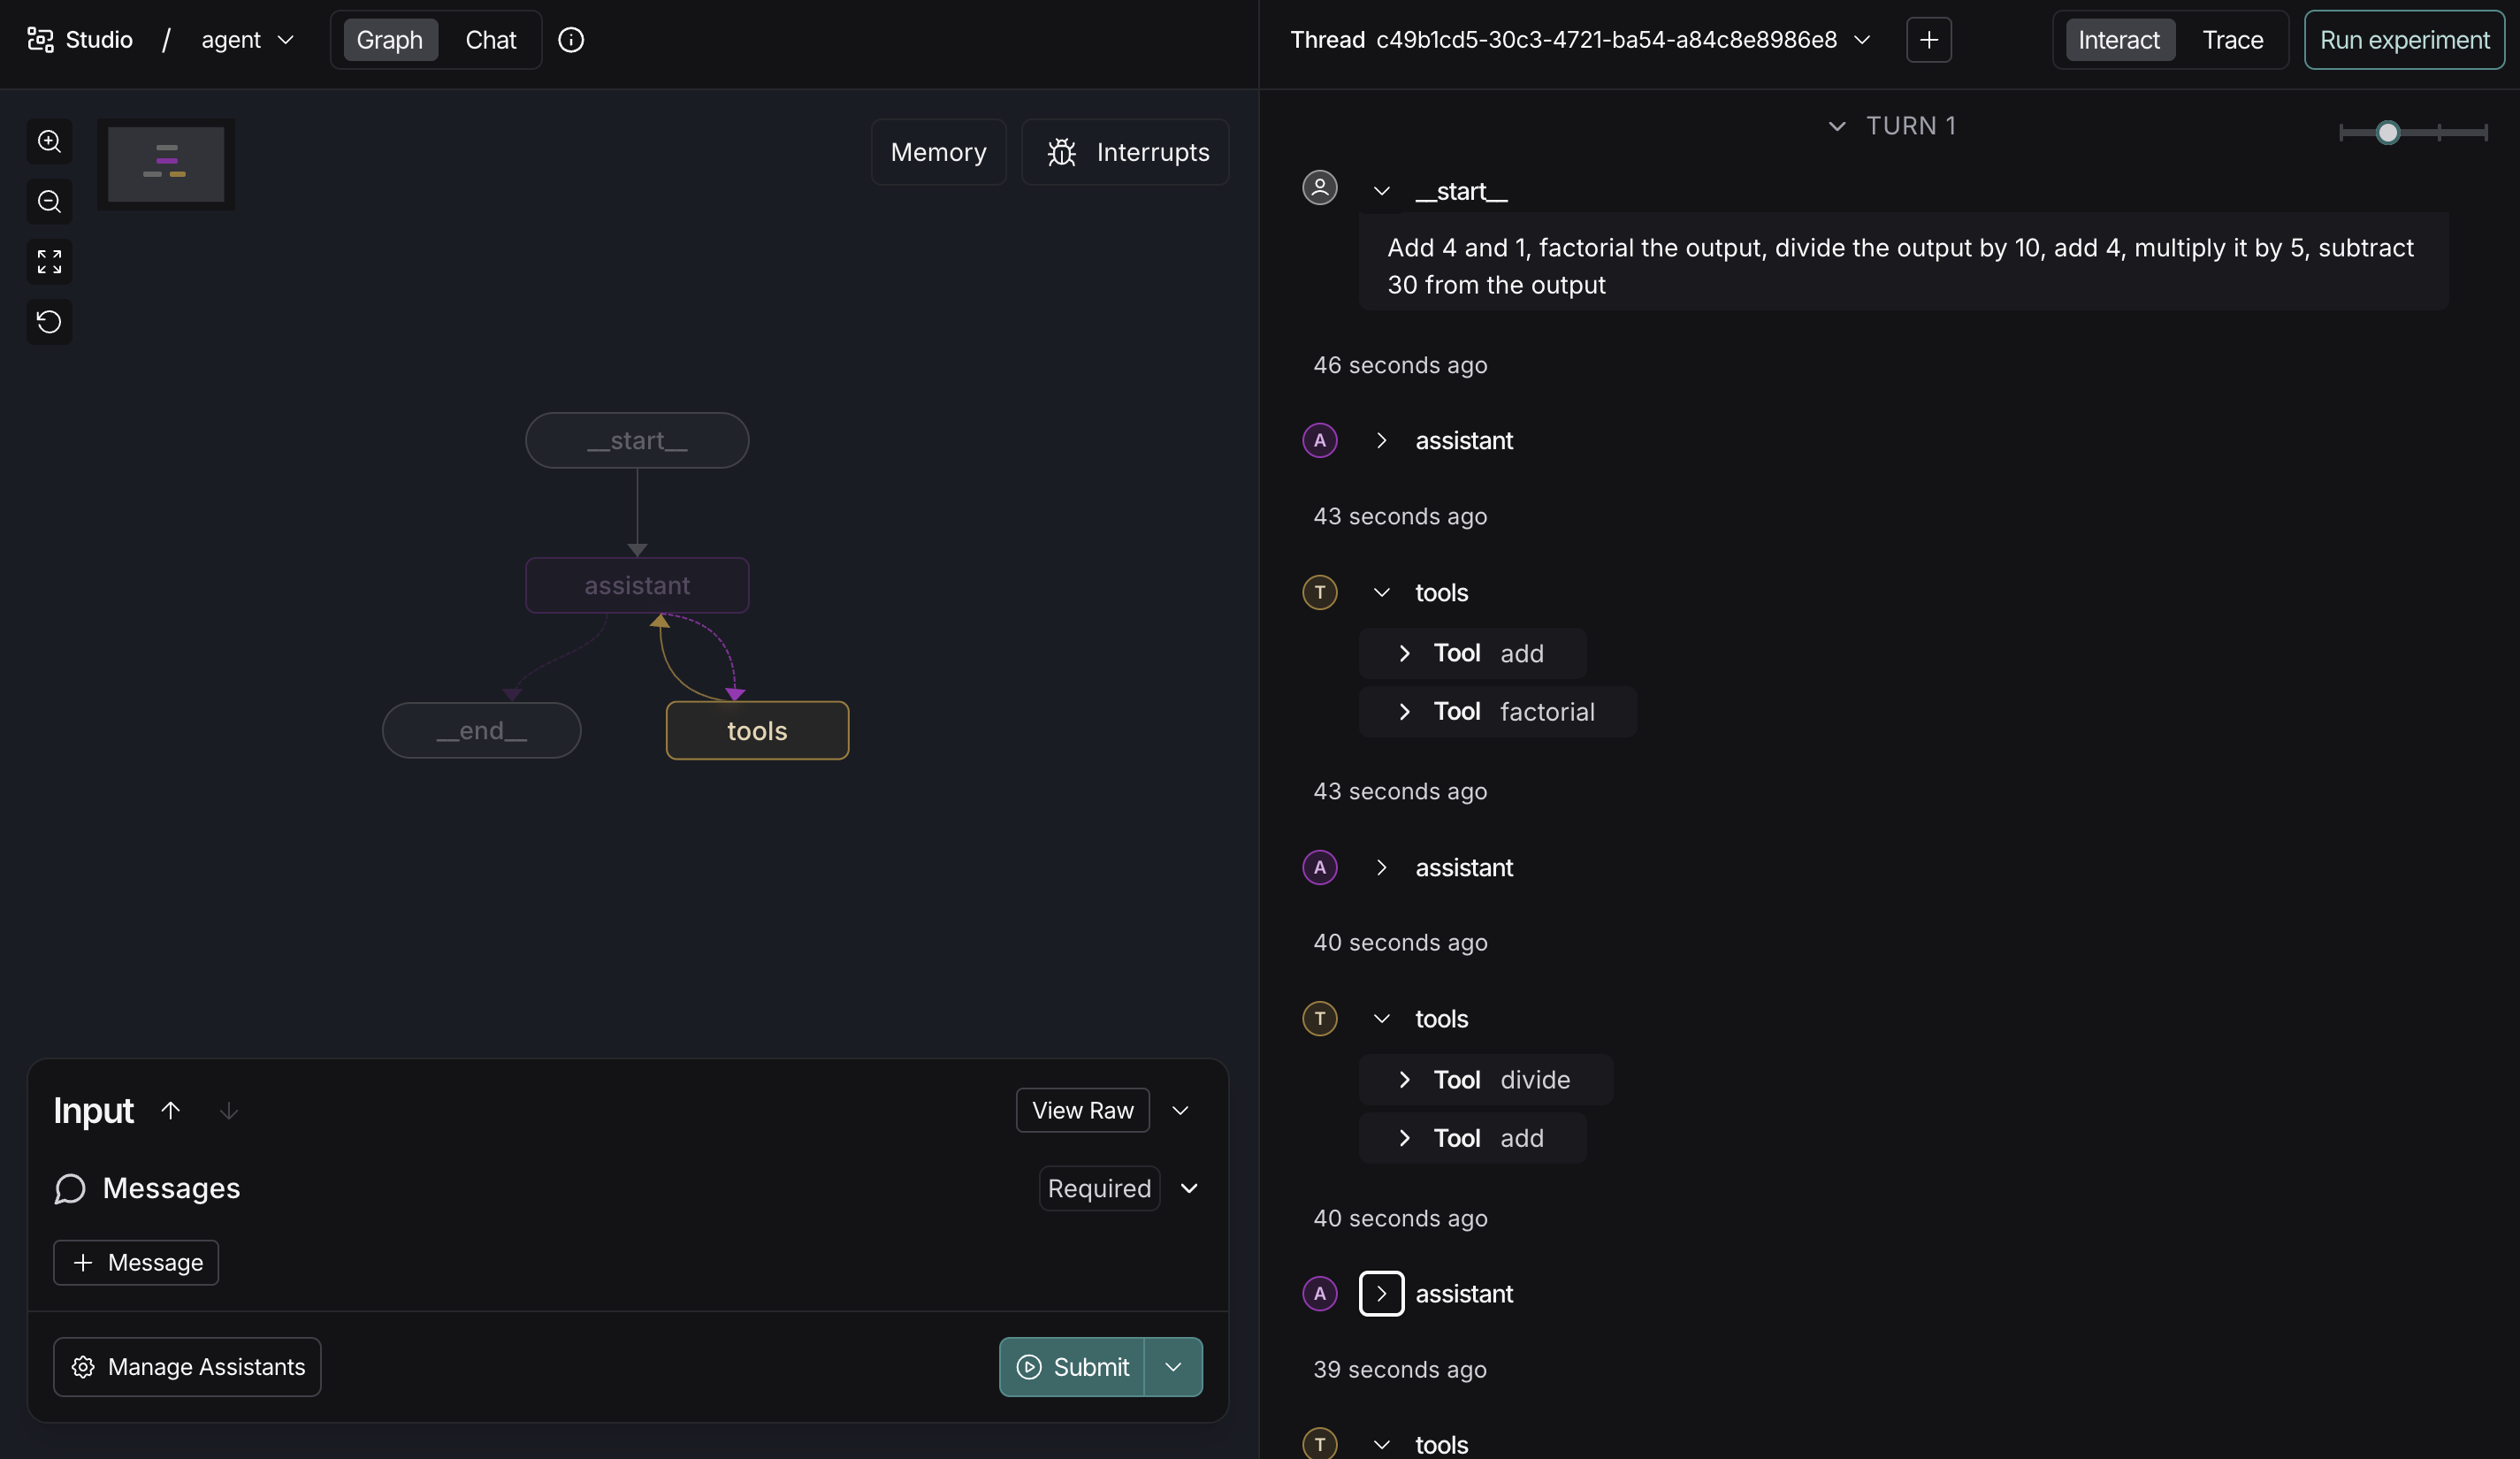

## We can also see the traces in the og Langsmith portal 

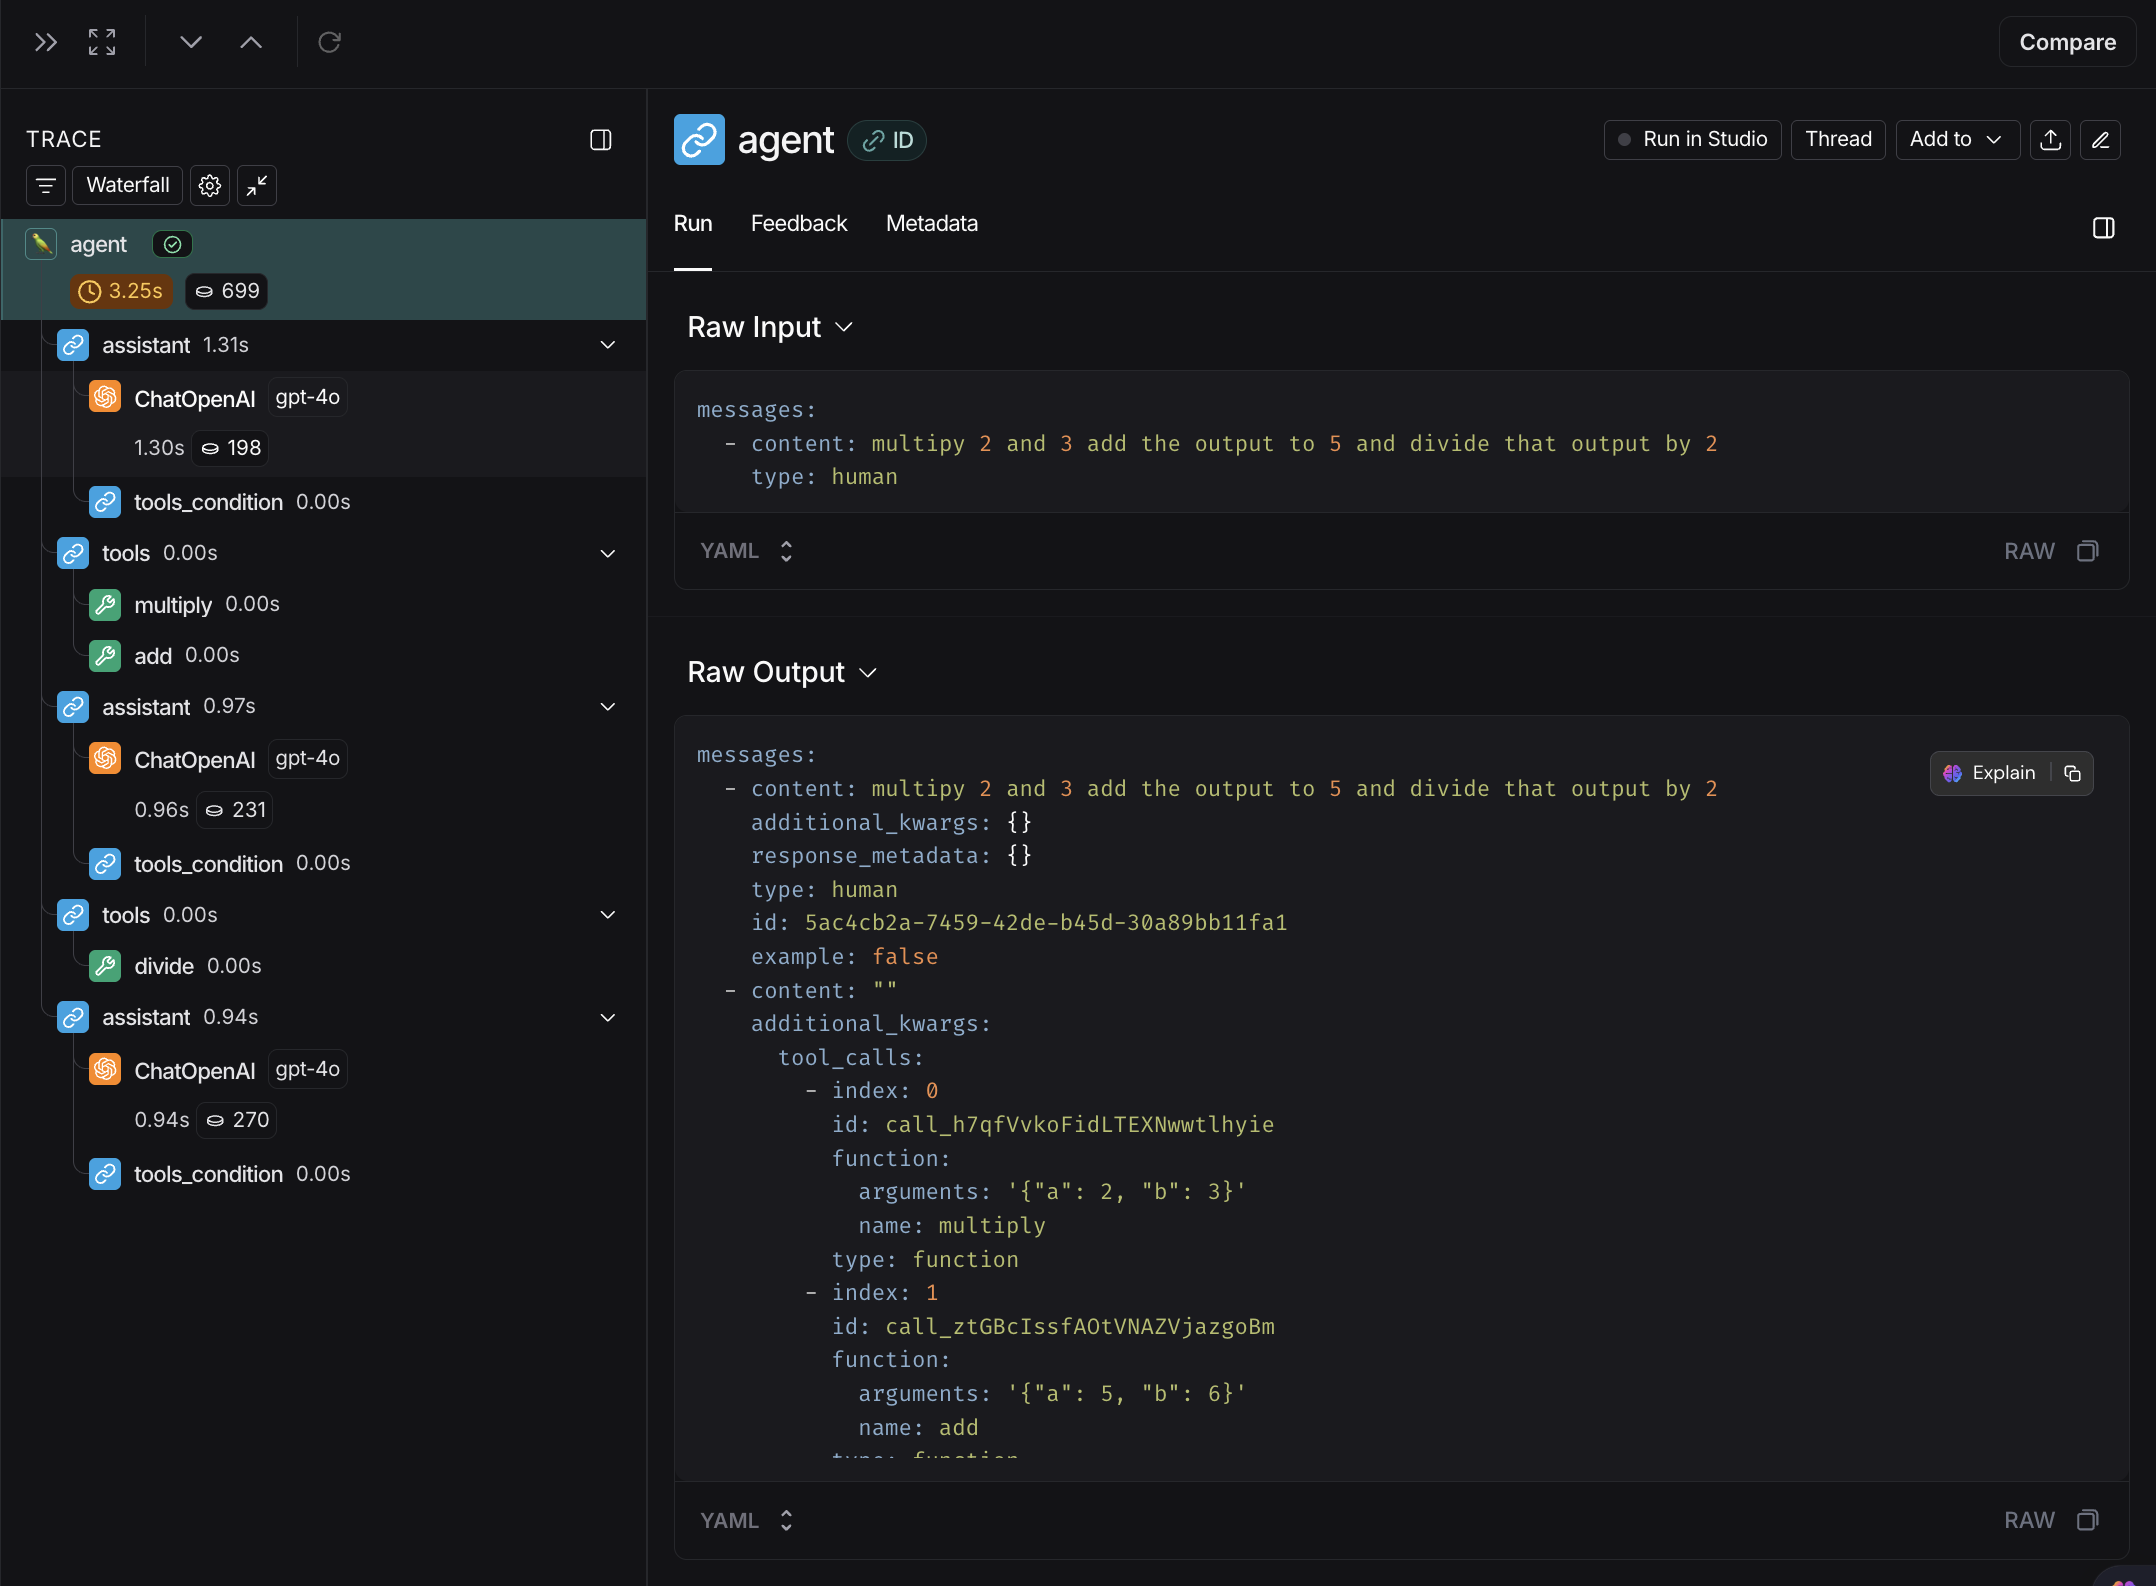

## it is very detailed and gives us a deeper dive into how each loop was actually executed under the hood